# Grid Size Experiment

In [1]:

import tarfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from experiments.multi_experiment import MultiExperiment
from experiments.grid_size.experiment import GridSizeExperiment
from functools import reduce
from parse import parse

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
import os
from pathlib import Path


def create_df(path: str = "../../data_store/grid_size") -> pd.DataFrame:
    path = Path(path)
    tar_files = ["grid_size.tar", "grid_size_conv2_nrun_5.tar"]  

    for file in [path / tar for tar in tar_files]:
        with tarfile.open(file, "r:*") as tar:
            for f in tar.getnames():
                result = parse("{layer_name}_x_{i}_{j}_{row}_{col}/train_statistics/fitness/{file}", f)
                if result is not None:
                    experiment = "{layer_name}_x_{i}_{j}_{row}_{col}".format(**result.named)
                    csv = pd.read_csv(tar.extractfile(f))
                    csv["grid"] = f'{result["row"]},{result["col"]}'
                    csv["experiment"] = experiment
                    yield csv
    

relevant_columns = ["error", "energy", "area", "delay", "gate_count"]
fitness_columns = ["error", "quantized_energy", "area", "quantized_delay", "gate_count"]
quantized_columns = ["error", "quantized_energy", "quantized_delay"]
# experiment = Experiment.with_data_only("../../data_store/zero_outter/conv1_0_0")
df = pd.concat([df for df in create_df()], ignore_index=True)
df.drop(columns="depth", inplace=True, errors="ignore")
df.drop_duplicates(subset=["generation"], inplace=True)
df.loc[df["run"] > 30, :]


,run,generation,timestamp,error,quantized_energy,energy,area,quantized_delay,delay,gate_count,chromosome,grid,experiment


## Data Exploration Analysis

In [22]:
df.describe()

,run,generation,timestamp,error,quantized_energy,energy,area,quantized_delay,delay,gate_count
count,23288.000000,2.328800e+04,23288.000000,23288.000000,2.328800e+04,23288.000000,23288.000000,2.328800e+04,23288.000000,23288.000000
mean,15.361774,2.041273e+05,37.999293,199.056682,7.179006e+17,0.194833,800.872738,4.217160e+18,1.072634,25.625386
std,8.707879,3.366785e+05,70.116055,1065.606864,1.114439e+18,0.175128,520.931912,2.608703e+18,0.502002,11.257439
min,1.000000,1.000000e+00,0.000196,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,4.000000
25%,8.000000,1.164650e+04,1.369688,0.000000,1.117984e+17,0.052228,395.502570,2.400604e+18,0.690000,20.000000
50%,15.000000,5.226400e+04,9.157287,0.000000,3.303312e+17,0.160409,689.870987,3.512462e+18,0.990000,25.000000
75%,23.000000,2.380298e+05,38.072209,30.000000,7.992948e+17,0.278853,1100.977785,5.540341e+18,1.370000,33.000000
max,30.000000,3.467307e+06,685.743964,70811.000000,1.383506e+19,1.434677,3932.733978,1.844674e+19,3.460000,60.000000


In [23]:
generation_df = df.copy()

runs = generation_df["run"].unique()
grids = generation_df["grid"].unique()
new_dfs = []
for grid in grids:
    for run in runs:
        run_df = generation_df.loc[(generation_df["run"] == run) & (generation_df["grid"] == grid), :]
        run_df["generation_delta"] = run_df["generation"].diff()
        
        for col in fitness_columns:
            if col != "area":
                run_df[f"{col}_delta"] = run_df[col].diff()
            else:
                run_df[f"{col}_delta"] = run_df[col]
        run_df = run_df.iloc[1:]
        for col in fitness_columns:
            run_df[f"{col}_delta"] = run_df[f"{col}_delta"].apply(lambda x: x if x < 0 else 0)

        zero_deltas = [run_df[f"{col}_delta"] == 0 for col in fitness_columns]
        run_df = run_df.loc[~reduce(lambda a, b: a & b, zero_deltas), :]
        run_df["run"] = run
        new_dfs.append(run_df)


dfs_delta = pd.concat(new_dfs)
epoch = 100000
for gen in range(0, dfs_delta["generation"].max() + epoch, epoch):
    dfs_delta.loc[dfs_delta["generation"].isin(range(gen, gen+epoch)), "generation"] = gen


# dfs_delta.iloc[dfs_delta["generation_delta"].idxmax()]

C:\Users\Majo\AppData\Local\Temp\ipykernel_29568\3360949041.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_df["generation_delta"] = run_df["generation"].diff()
C:\Users\Majo\AppData\Local\Temp\ipykernel_29568\3360949041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_df[f"{col}_delta"] = run_df[col].diff()
C:\Users\Majo\AppData\Local\Temp\ipykernel_29568\3360949041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

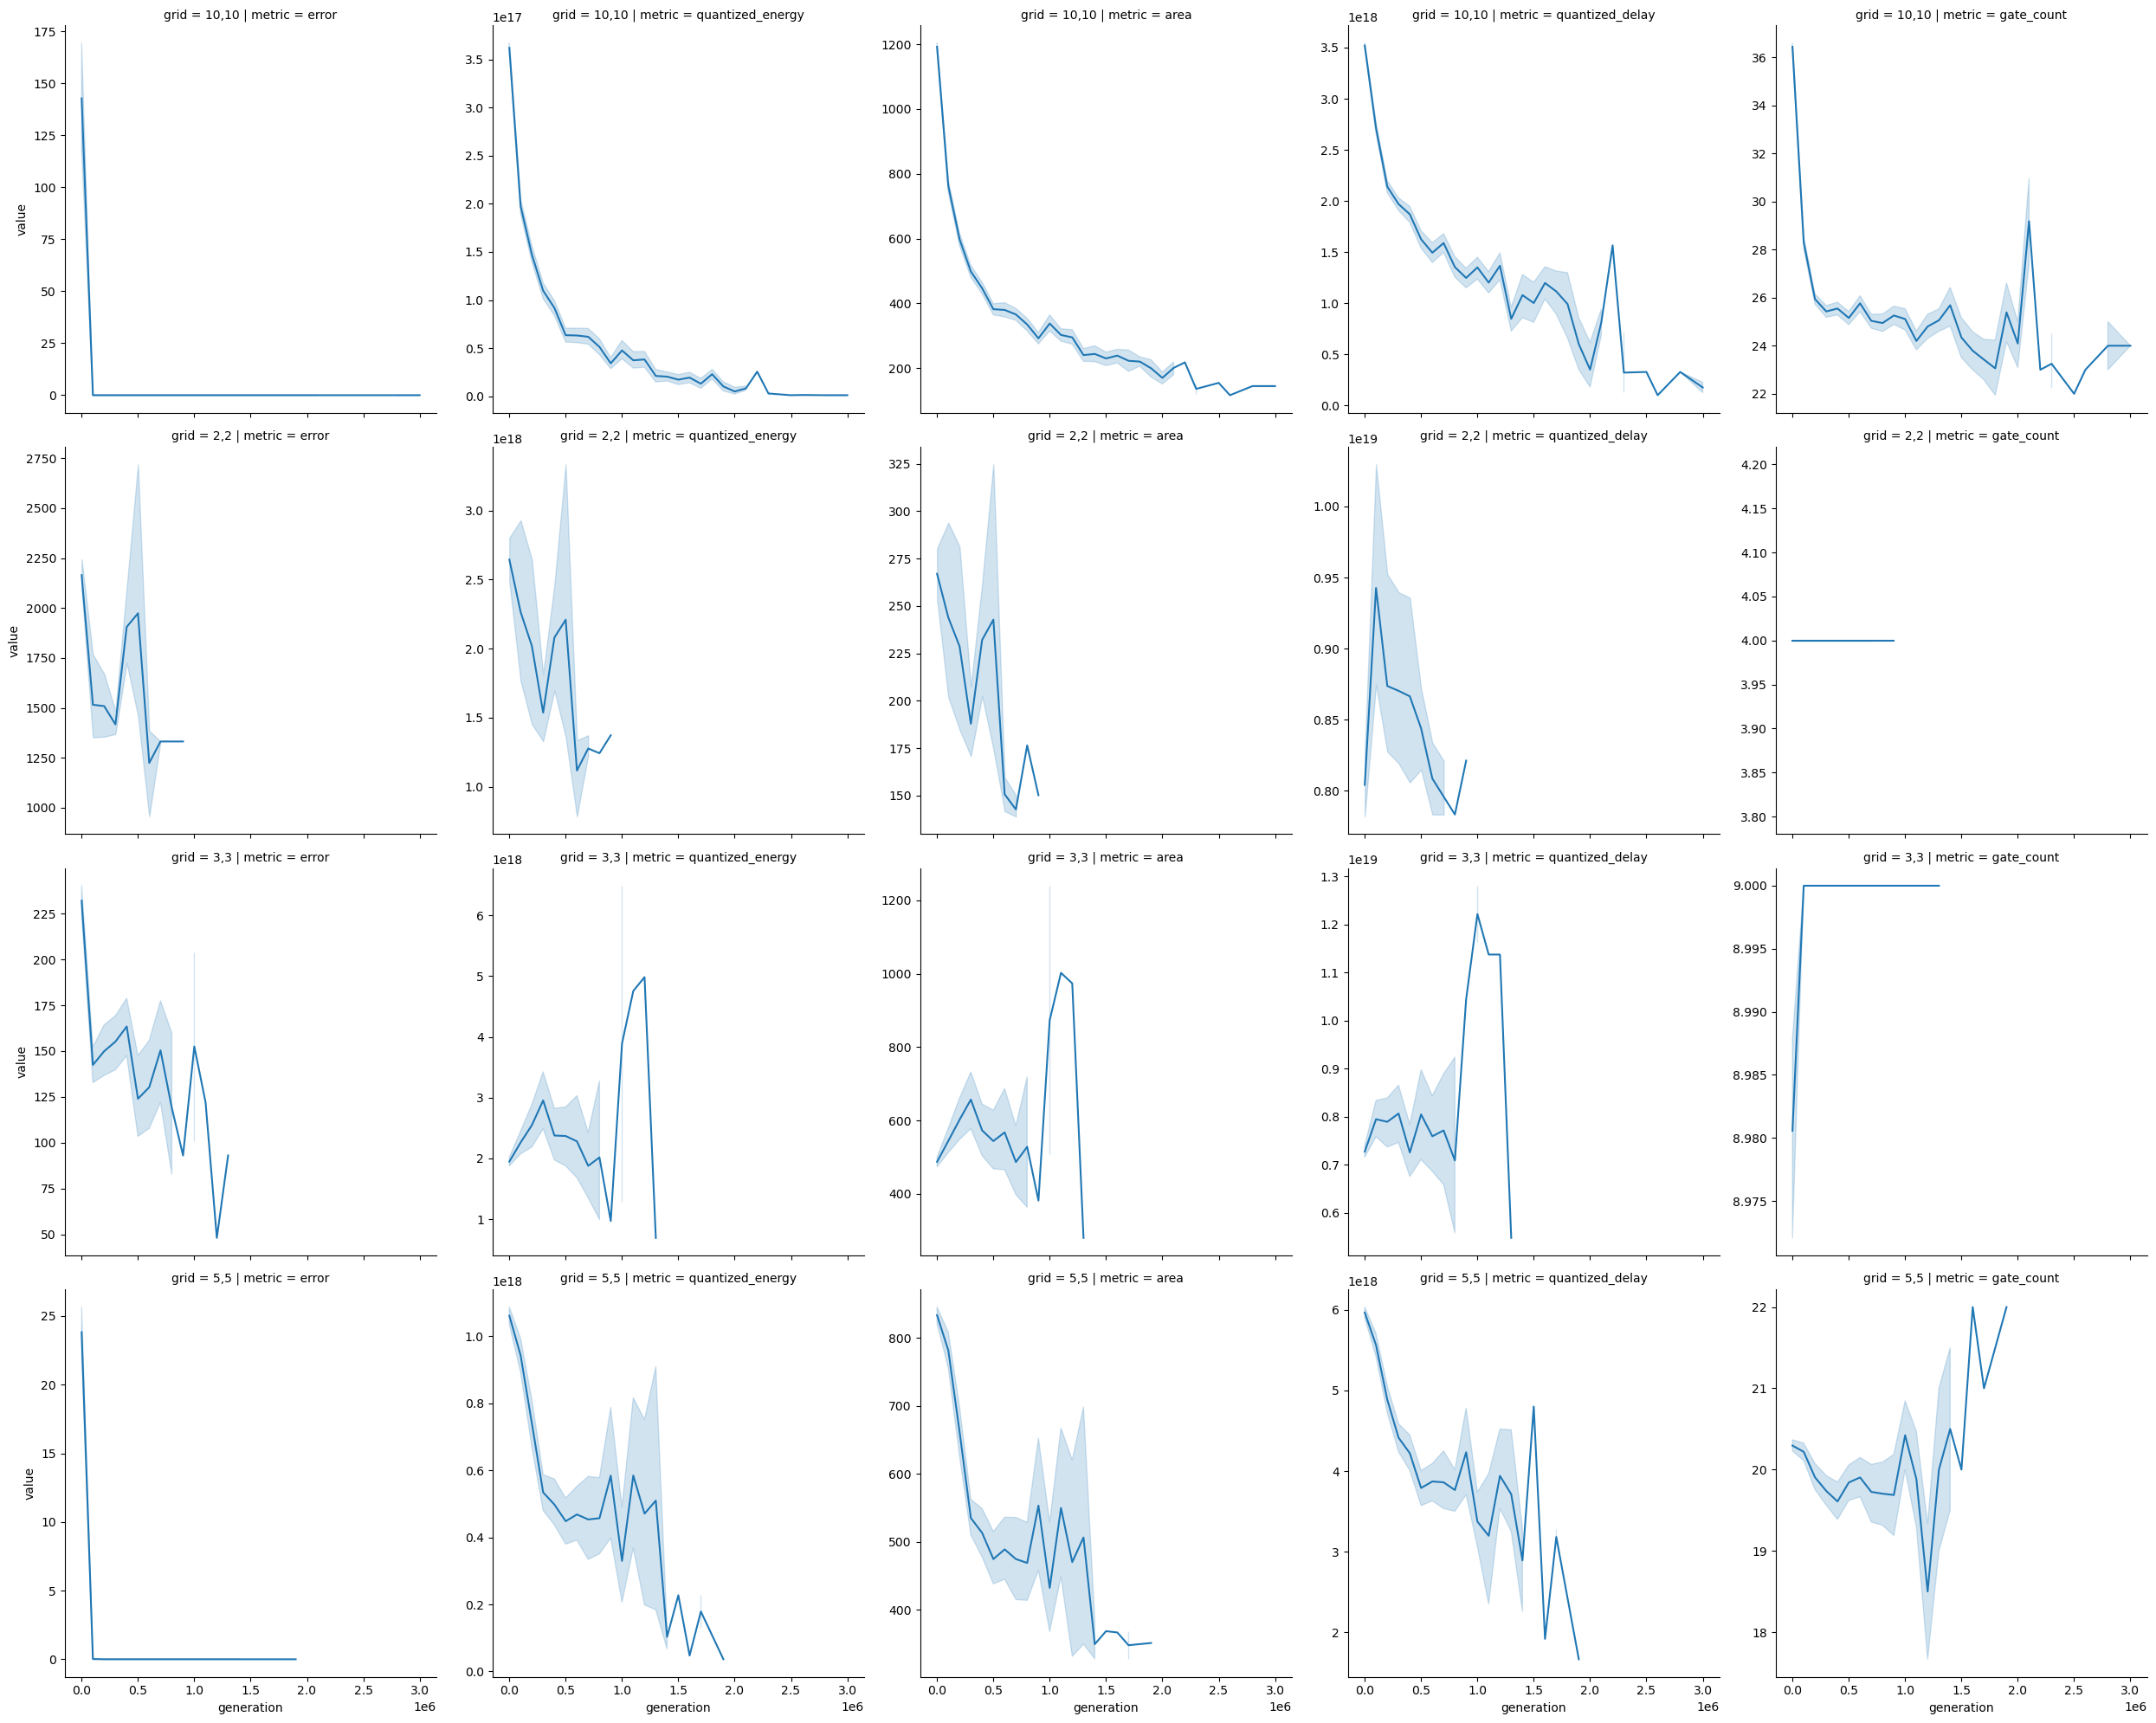

In [24]:
plot_df = pd.melt(dfs_delta, id_vars=["generation", "grid"], value_vars=fitness_columns, var_name="metric")

sns.relplot(data=plot_df, x="generation", y="value", row="grid", col="metric", kind="line", facet_kws={"sharey": False, "sharex": True})

## Data Preparation

In [25]:
clean_df = df.copy()

for run in range(1, experiment.get_number_of_train_statistic_file() + 1):
    condition = (clean_df["run"] == run) & (clean_df["generation"].isna())
    clean_df.loc[condition, relevant_columns] = clean_df.loc[condition, relevant_columns].min()

# clean_df.loc[clean_df["error"].isna(), :].tail(20)
clean_df

NameError: name 'experiment' is not defined

## Learning Rate

In [ ]:
learn_df = pd.concat([pd.read_csv(x) for x in experiment.get_learn_rate_statistics(runs=1)])
learn_df

FileNotFoundError: [Errno 2] No such file or directory: '..\\..\\data_store\\reversed_single_filter\\conv2_0_0_5_5\\train_statistics\\learning\\learning_rate.1.csv'

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


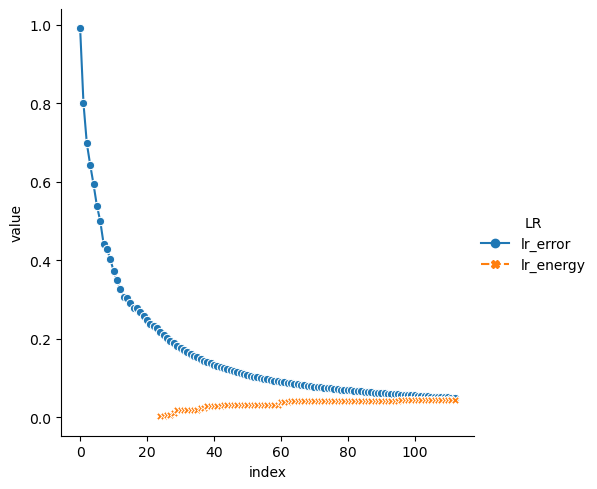

In [ ]:
table_df = pd.melt(learn_df.reset_index(inplace=False), id_vars=["index"], value_vars=["lr_error", "lr_energy"], var_name="LR")
# table_df = table_df.loc[table_df["index"].isin(range(60, 71))]
# Filter the dataframe for the first set of data (lr_error)
a = table_df.loc[table_df["LR"] == "lr_error"]
b = table_df.loc[table_df["LR"] == "lr_energy"]
# a.loc[table_df["value"] == 0, "value"] = a["value"].max()
# b.loc[table_df["value"] == 0, "value"] = b["value"].max()
table_df.loc[(table_df["value"] == 0) & (table_df["LR"] == "lr_error"), "value"] = a.loc[table_df["LR"] == "lr_error", "value"].max()
table_df.loc[(table_df["value"] == 0) & (table_df["LR"] == "lr_energy"), "value"] = a.loc[table_df["LR"] == "lr_energy", "value"].max()

# Plot the first set of data
ax = sns.relplot(data=table_df, x="index", y="value", hue="LR", style="LR", markers=True, kind="line")
# ax2 = plt.twinx()
# ax = sns.lineplot(data=b, x="index", y="value", color="orange", style="LR", markers=True, ax=ax2)


## Evolution Progress

C:\Users\Majo\AppData\Local\Temp\ipykernel_20136\2664694428.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantized_df = filtered_df.loc[:, relevant_columns + ["run"]].groupby(by=[quantizer, "run"]).mean()
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-pa

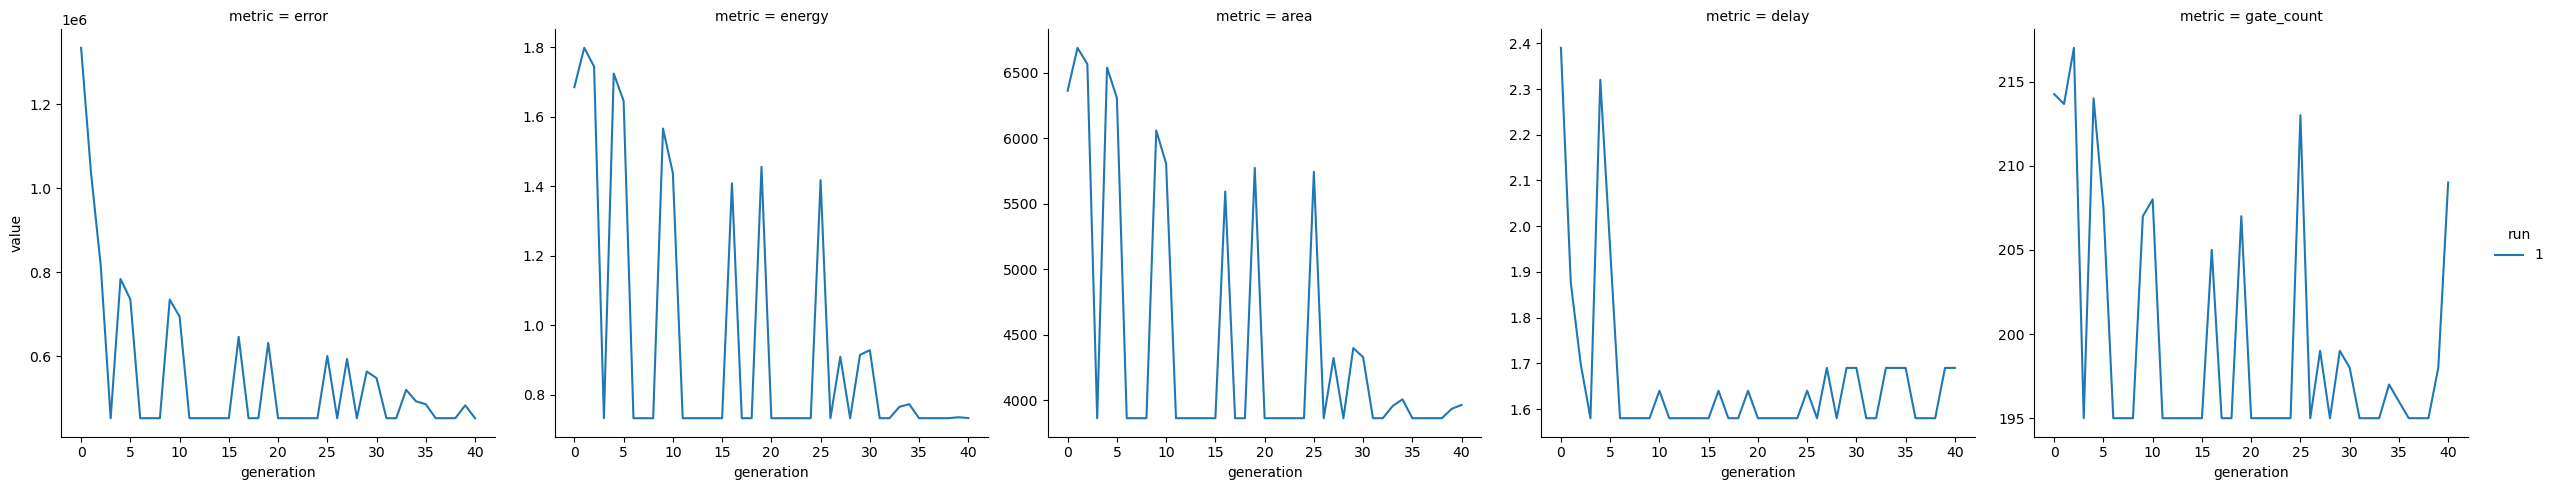

''

In [ ]:
generation_group = 10
bin_quantity = 50
# Create a 2x3 subplot layout
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))

filtered_df = clean_df.loc[clean_df["generation"] <= (generation_group * bin_quantity), :]

bins = np.arange(0, filtered_df["generation"].max() + generation_group, generation_group)
quantizer = pd.cut(filtered_df["generation"], bins=bins)
quantized_df = filtered_df.loc[:, relevant_columns + ["run"]].groupby(by=[quantizer, "run"]).mean()
quantized_df.reset_index(inplace=True)

for run in range(1, experiment.get_number_of_train_statistic_file() + 1):
    condition = (quantized_df["run"] == run) & (quantized_df["error"].isna())
    for col in relevant_columns:
        quantized_df.loc[condition, col] = quantized_df.loc[quantized_df["run"] == run, col].min(skipna=True)


quantized_df = pd.melt(quantized_df, id_vars=["run", "generation"], value_vars=relevant_columns, var_name="metric", value_name="value")
quantized_df["generation"] = quantized_df["generation"].cat.codes
quantized_df = quantized_df.loc[quantized_df["generation"] < 50, :]
sns.relplot(data=quantized_df, x="generation", y="value", hue="run", col="metric", kind="line", facet_kws={"sharey": False})
plt.show()
;

,run,generation,timestamp,error,energy,area,delay,gate_count,chromosome
0,1,1,0.001519,1366186,1.583041,6041.768147,2.39,208,NaN
1,1,4,0.001879,1331970,1.733477,6519.984843,2.39,217,NaN
2,1,5,0.002055,1326799,1.713366,6455.690740,2.39,215,NaN
3,1,6,0.002234,1311941,1.713038,6427.063440,2.39,217,NaN
4,1,13,0.002933,1279509,1.861904,6801.564838,2.39,217,NaN
...,...,...,...,...,...,...,...,...,...
834,1,14636139,968.967559,50,0.743364,2714.431180,0.74,95,"{54,96,15,30,2,15,5}([54]49,23,13)([55]39,37,6..."
835,1,14840671,986.479433,50,0.743364,2714.431180,0.74,94,"{54,96,15,30,2,15,5}([54]49,23,13)([55]39,37,6..."
836,1,16274404,1084.227558,50,0.743364,2714.431180,0.74,93,"{54,96,15,30,2,15,5}([54]49,23,13)([55]39,37,6..."
837,1,16496758,1098.931182,50,0.743249,2695.659181,0.74,92,"{54,96,15,30,2,15,5}([54]49,23,13)([55]39,37,6..."


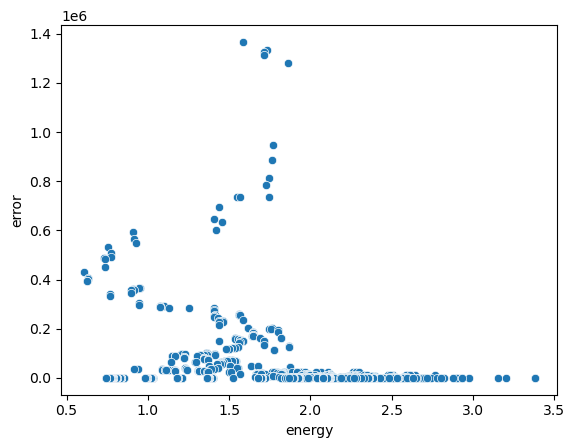

In [ ]:
sns.scatterplot(data=clean_df.loc[clean_df["error"].notna() & clean_df["energy"].notna()], x="energy", y="error")
# plt.show()
clean_df